In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from collections import defaultdict
from scipy.stats import spearmanr, pearsonr
import requests

In [2]:
data = pd.read_csv("/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/PTV1_protein_matrix_test.cleaned.tsv", index_col=0, sep="\t")
data.head()

,B1422,B3832,B3637,B3772,B1362,B3577,B1302,B3712,B3517,B3607,...,2083,3502,1732,1368,3495,1347,1718,3488,3184,1326
uniprotID,,,,,,,,,,,,,,,,,,,,,
Q8WUW1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,331.708,736.431,479.634,1253.65,1186.470,574.439,1331.43,NaN,833.68
Q9NRR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,10591.100,11457.100,11083.70,NaN,12026.500,NaN,13366.40,NaN
Q99747,NaN,877.276,312.174,1059.98,563.924,NaN,NaN,1612.48,NaN,1048.42,...,3445.44,4091.470,3998.610,3721.100,4367.20,2928.310,3748.900,2163.31,3644.37,2935.57
P10398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,941.064,659.621,1343.350,1089.05,713.629,610.925,1452.92,NaN,1057.48
P05198,4614.75,5924.430,5228.960,6652.65,5161.500,4547.95,4879.84,5512.30,5737.22,5928.58,...,16682.00,16277.600,14734.400,14565.700,16408.20,16053.000,16025.200,14728.90,14380.40,15590.70


In [3]:
# Load screen information
screen_info = pd.read_excel("/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/PTV1_sample_info_test.xlsx", sheet_name=0)  # First sheet is single perturbation info
screen_info.head()

,Sample_ID,pert_id,pert_name,pert_time,cell_line,BioRep,machine
0,B1422,#58,Paclitaxel,48,DU4475,1,D
1,B3832,#58,Paclitaxel,48,DU4475,2,D
2,B3637,#58,Paclitaxel,48,DU4475,3,D
3,B3772,#58,Paclitaxel,24,DU4475,1,D
4,B1362,#58,Paclitaxel,24,DU4475,2,D


In [4]:
# Get unique cell lines
cell_lines = pd.unique(screen_info["cell_line"])
print(f"{len(cell_lines)} cell lines")

# Get sample IDs corresponding to controls for each cell line
control_ids = {}
for cell_line in cell_lines:
    control_ids[cell_line] = list(screen_info.loc[(screen_info["cell_line"] == cell_line) & (screen_info["pert_id"] == "no"), "Sample_ID"].values)

# Segment data by cell line and remove lines with fewer than 100 samples
data_by_cell_line = {}
for cell_line in cell_lines:
    data_cell = data.loc[:, screen_info.loc[screen_info["cell_line"] == cell_line, "Sample_ID"]]
    if data_cell.shape[1] >= 100:
        data_by_cell_line[cell_line] = data_cell
        print(f"{cell_line}: {data_by_cell_line[cell_line].shape[1]} samples")
cell_lines = list(data_by_cell_line.keys())

14 cell lines
DU4475: 516 samples
MCF7: 408 samples
HS578T: 357 samples
HCC70: 417 samples
BT549: 534 samples
MDA-MB-453: 516 samples


In [5]:
# Get control samples for each cell line
control_data = {}
for cell_line in cell_lines:
    control_cell = data_by_cell_line[cell_line][control_ids[cell_line]]
    
    # Drop rows with missing values
    control_cell = control_cell.dropna()
    control_data[cell_line] = control_cell

<Figure size 640x480 with 0 Axes>

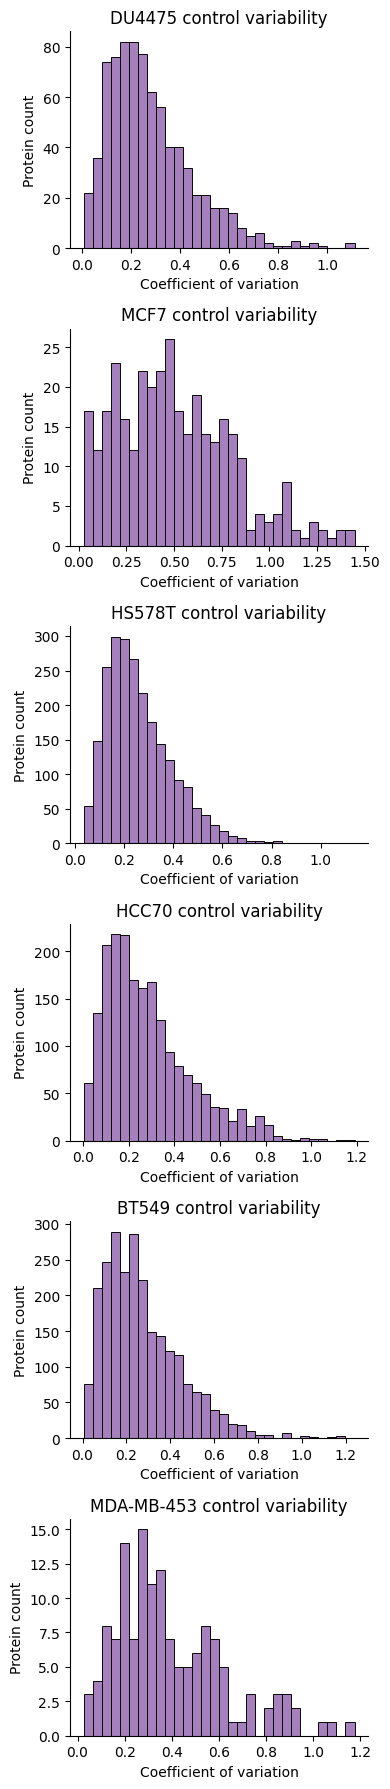

In [6]:
# Generate plots of control variability for each gene across replicates for each cell line
plt.clf()
fig, axes = plt.subplots(len(cell_lines), 1, figsize=(4, 3 * len(cell_lines)))
for i, cell_line in enumerate(cell_lines):
    control_cell = control_data[cell_line]
    control_cell["Standard deviation"] = control_cell.std(axis=1)
    # Compute coefficient of variation
    control_cell["Coefficient of variation"] = control_cell["Standard deviation"] / control_cell.mean(axis=1)
    sns.histplot(control_cell["Coefficient of variation"], bins=30, color="#8856a7", ax=axes[i])
    sns.despine()
    axes[i].set_title(f"{cell_line} control variability")
    axes[i].set_xlabel("Coefficient of variation")
    axes[i].set_ylabel("Protein count")

plt.tight_layout()
plt.show()

In [7]:
# Retain only proteins with lower coefficient of variability across controls and take their mean across replicates
min_cv = 0.8
low_cv_controls = {}
for cell_line in cell_lines:
    control_cell = control_data[cell_line]
    control_cell["Standard deviation"] = control_cell.std(axis=1)
    # Compute coefficient of variation
    control_cell["Coefficient of variation"] = control_cell["Standard deviation"] / control_cell.mean(axis=1)
    low_cv_controls_cell = control_cell.loc[control_cell["Coefficient of variation"] < min_cv, :].mean(axis=1)
    print(f"{cell_line}: {low_cv_controls_cell.shape[0]} proteins with CV < {min_cv}")
    low_cv_controls[cell_line] = low_cv_controls_cell

DU4475: 746 proteins with CV < 0.8
MCF7: 212 proteins with CV < 0.8
HS578T: 2302 proteins with CV < 0.8
HCC70: 1833 proteins with CV < 0.8
BT549: 2288 proteins with CV < 0.8
MDA-MB-453: 116 proteins with CV < 0.8


In [8]:
# Subset cell line data to only include proteins with low CV
data_low_cv = {}
for cell_line in cell_lines:
    data_low_cv[cell_line] = data_by_cell_line[cell_line].loc[low_cv_controls[cell_line].index, :]

data_low_cv[cell_lines[0]]

,B1422,B3832,B3637,B3772,B1362,B3577,B1302,B3712,B3517,B3607,...,B3521,B3591,B1376,B3786,B3531,B1316,B3726,B1256,B3471,B3666
uniprotID,,,,,,,,,,,,,,,,,,,,,
P05198,4614.75,5924.43,5228.96,6652.65,5161.50,4547.95,4879.84,5512.30,5737.22,5928.58,...,5331.86,4378.02,4443.04,5254.17,4625.03,4892.34,5193.49,4804.02,NaN,5761.43
P49257,7426.15,6034.68,8712.97,7910.26,8142.46,8509.96,7293.14,6897.21,10738.90,8665.64,...,7588.78,10037.80,9325.50,8778.02,6620.51,4863.25,8905.24,6834.92,NaN,7321.85
P33993,9791.54,10445.30,10213.10,11367.40,9120.92,11664.60,7884.33,10690.50,9275.70,8817.40,...,10530.20,11724.30,10339.10,11445.50,10771.50,9144.08,11043.40,8892.78,NaN,10260.50
P41240,1719.40,2824.24,3027.35,3638.31,3193.35,2733.89,2679.07,3453.87,3953.78,3424.52,...,3242.68,2729.49,1551.03,3243.18,2064.38,1464.23,3728.92,3034.00,NaN,3316.09
Q13185,9201.70,10841.00,8528.85,10415.00,10236.70,10026.80,10031.10,8343.59,10199.20,8112.02,...,8700.57,6552.27,7916.98,6457.91,8056.87,7734.92,6690.25,9746.20,NaN,8486.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q99832,10816.00,11654.80,12628.30,12922.40,8629.45,12881.10,9260.91,11586.50,12467.90,10628.80,...,12220.60,13335.60,9606.84,11246.60,11019.10,7172.98,12577.20,8066.20,NaN,12922.00
Q14697,29518.10,31719.10,31691.70,32557.60,27495.70,32106.30,29447.70,35247.70,35251.20,26241.20,...,33015.30,35863.70,27968.30,34913.20,32934.60,25865.20,36546.50,24567.70,NaN,34734.50
P24752,5740.69,7845.05,6448.17,7007.41,4312.27,7675.96,4976.10,7192.93,6838.98,8373.06,...,6079.47,7892.23,4670.11,7222.60,6107.59,4510.79,7523.89,6393.95,NaN,6254.83


<Figure size 640x480 with 0 Axes>

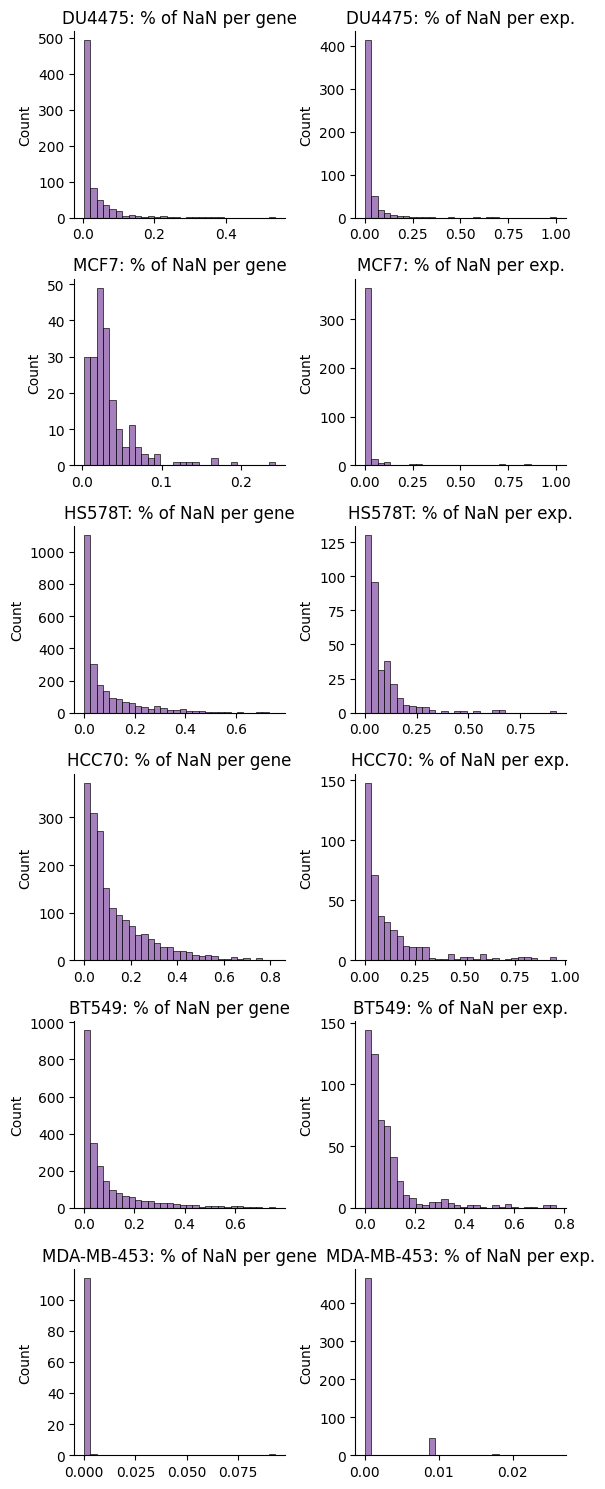

In [9]:
# Plot distribution of missing values across rows (genes) and columns (experiments) for each cell line
plt.clf()
fig, axes = plt.subplots(len(cell_lines), 2, figsize=(6, 2.5 * len(cell_lines)))
for i, cell_line in enumerate(cell_lines):
    data_low_cv_cell = data_low_cv[cell_line]
    sns.histplot(data_low_cv_cell.isna().sum(axis=1) / data_low_cv_cell.shape[1], ax=axes[i, 0], bins=30, color="#8856a7")
    axes[i, 0].set_title(f"{cell_line}: % of NaN per gene")
    sns.histplot(data_low_cv_cell.isna().sum(axis=0) / data_low_cv_cell.shape[0], ax=axes[i, 1], bins=30, color="#8856a7")
    axes[i, 1].set_title(f"{cell_line}: % of NaN per exp.")
    sns.despine(ax=axes[i, 0])
    sns.despine(ax=axes[i, 1])

plt.tight_layout()
plt.show()

In [10]:
# Remove any columns from each cell line DataFrame that has mean values way larger than the rest
data_low_cv_no_outlier = {}
for cell_line in cell_lines:
    data_low_cv_cell = data_low_cv[cell_line]
    data_low_cv_cell = data_low_cv_cell.loc[:, data_low_cv_cell.mean() < 10 * data_low_cv_cell.mean().mean()]
    print(f"{cell_line}: {data_low_cv_cell.shape[0]} proteins, {data_low_cv_cell.shape[1]} experiments")
    data_low_cv_no_outlier[cell_line] = data_low_cv_cell

# Create a name mapper from `sample_id` to `{pert_id}_{time}` to apply to each DataFrame
name_mapper = {}
for tup in screen_info.itertuples():
    _, sample_id, pert_id, pert_name, pert_time, cell_line, replicate, _ = tup
    if pert_id == "no":
        continue

    pert_id = f"{pert_name}_{pert_id.replace('#', '')}"
    name_mapper[sample_id] = f"{pert_id}_{pert_time}"

# Rename columns of cell line DataFrames
data_low_cv_renamed = {}
for cell_line in cell_lines:
    data_low_cv_cell = data_low_cv_no_outlier[cell_line]
    data_low_cv_cell = data_low_cv_cell.rename(columns=name_mapper)
    
    # Group by columns to take mean over replicates, ignoring NaNs
    data_low_cv_cell = data_low_cv_cell.T.groupby(data_low_cv_cell.columns).mean().T  # Have to transpose to avoid warning
    data_low_cv_renamed[cell_line] = data_low_cv_cell
    

# For each cell line, rows with >5% missing values and impute missing values using column mean
data_low_cv_clean = {}
for cell_line in cell_lines:
    data_low_cv_cell = data_low_cv_renamed[cell_line]
    data_low_cv_cell = data_low_cv_cell.loc[data_low_cv_cell.isna().sum(axis=1) / data_low_cv_cell.shape[1] < 0.05, :]
    data_low_cv_cell = data_low_cv_cell.fillna(data_low_cv_cell.mean(axis=0))
    print(f"{cell_line}: {data_low_cv_cell.shape[0]} proteins, {data_low_cv_cell.shape[1]} experiments")
    data_low_cv_clean[cell_line] = data_low_cv_cell
data_low_cv_clean[cell_lines[0]]

# arcsin log(1+x) tanh
# BT549 HS578T <- TNBC

DU4475: 746 proteins, 515 experiments
MCF7: 212 proteins, 407 experiments
HS578T: 2302 proteins, 356 experiments
HCC70: 1833 proteins, 414 experiments
BT549: 2288 proteins, 534 experiments
MDA-MB-453: 116 proteins, 516 experiments
DU4475: 743 proteins, 174 experiments
MCF7: 212 proteins, 138 experiments
HS578T: 2154 proteins, 123 experiments
HCC70: 1605 proteins, 141 experiments
BT549: 2145 proteins, 180 experiments
MDA-MB-453: 116 proteins, 174 experiments


,Abemaciclib_10_24,Abemaciclib_10_48,Abemaciclib_10_6,Afatinib Dimaleate_21_24,Afatinib Dimaleate_21_48,Afatinib Dimaleate_21_6,Alpelisib_8_24,Alpelisib_8_48,Alpelisib_8_6,Aminolevulinic Acid Hydrochloride_46_24,...,Verteporfin_45_6,Vincristine Sulfate_67_24,Vincristine Sulfate_67_48,Vincristine Sulfate_67_6,Vorinostat_33_24,Vorinostat_33_48,Vorinostat_33_6,Zoledronic Acid Hydrate_43_24,Zoledronic Acid Hydrate_43_48,Zoledronic Acid Hydrate_43_6
uniprotID,,,,,,,,,,,,,,,,,,,,,
P05198,5947.813333,4140.790000,4661.740000,4073.476667,4458.860000,5954.536667,5177.920000,4298.863333,4361.323333,5236.056667,...,4865.040000,5160.120000,5377.570000,5451.356667,5414.590000,5263.163333,4585.893333,6222.350000,5646.583333,5927.820000
P49257,6478.170000,9096.970000,7779.890000,7267.336667,7622.940000,6133.310000,7582.770000,7666.803333,5390.945000,6951.670000,...,7993.580000,8228.405000,8675.950000,6921.216667,6409.520000,9412.393333,4079.430000,7721.523333,6550.503333,6996.083333
P33993,9088.066667,9625.783333,8908.093333,9453.313333,10527.543333,9983.790000,10363.700000,9918.086667,8348.960000,9864.780000,...,9342.156667,10276.070000,10446.753333,9404.713333,7976.003333,9660.250000,9293.650000,9618.496667,9804.733333,9656.930000
P41240,2721.286667,2596.743333,3373.713333,1913.373333,2254.373333,2421.656667,3441.066667,2156.723333,2725.945000,3279.810000,...,2247.390000,2788.000000,2923.433333,2348.323333,2671.176667,3086.836667,2920.590000,3056.326667,2978.626667,3047.636667
Q13185,9640.506667,8132.410000,8474.130000,8960.553333,8544.523333,8556.486667,7797.390000,9038.963333,9934.623333,8606.250000,...,8150.323333,9513.610000,10845.310000,9302.450000,7705.893333,6171.520000,7437.450000,8670.013333,9272.990000,8646.840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q99832,11446.120000,9761.443333,9732.830000,10801.043333,11129.136667,10462.026667,11190.333333,10722.913333,12486.626667,11142.766667,...,9231.900000,10649.143333,11499.426667,10455.480000,10500.526667,10238.196667,10756.970000,11221.466667,12262.900000,10719.166667
Q14697,30821.133333,30955.600000,28666.466667,30863.666667,32847.800000,29843.466667,32006.233333,29480.400000,26818.133333,27977.066667,...,21918.866667,28684.833333,31112.166667,28902.700000,30106.200000,31208.266667,29701.033333,29758.466667,29518.033333,28896.600000
P24752,5434.216667,6058.320000,6792.256667,5646.466667,5745.940000,5579.330000,6021.996667,5849.660000,6428.466667,6310.106667,...,4569.290000,7211.863333,6254.313333,5994.436667,6913.413333,6530.256667,5659.420000,5288.623333,5984.223333,6096.340000


In [11]:
# Perform log2 normalization on each cell type dataset using controls and then drop controls
data_normalized = {}
for cell_line in cell_lines:
    data_low_cv_clean_cell = data_low_cv_clean[cell_line]
    control_ids_cell = control_ids[cell_line]
    control_values = data_low_cv_clean_cell.loc[:, control_ids_cell].mean(axis=1)
    data_low_cv_clean_cell = np.log2(data_low_cv_clean_cell.divide(control_values, axis=0).drop(columns=control_ids_cell))
    data_normalized[cell_line] = data_low_cv_clean_cell
data_normalized[cell_lines[0]]

,Abemaciclib_10_24,Abemaciclib_10_48,Abemaciclib_10_6,Afatinib Dimaleate_21_24,Afatinib Dimaleate_21_48,Afatinib Dimaleate_21_6,Alpelisib_8_24,Alpelisib_8_48,Alpelisib_8_6,Aminolevulinic Acid Hydrochloride_46_24,...,Verteporfin_45_6,Vincristine Sulfate_67_24,Vincristine Sulfate_67_48,Vincristine Sulfate_67_6,Vorinostat_33_24,Vorinostat_33_48,Vorinostat_33_6,Zoledronic Acid Hydrate_43_24,Zoledronic Acid Hydrate_43_48,Zoledronic Acid Hydrate_43_6
uniprotID,,,,,,,,,,,,,,,,,,,,,
P05198,0.198283,-0.324170,-0.153207,-0.347815,-0.217401,0.199913,-0.001703,-0.270121,-0.249310,0.014405,...,-0.091624,-0.006671,0.052878,0.072539,0.062776,0.021854,-0.176873,0.263384,0.123302,0.193426
P49257,-0.268242,0.221558,-0.004078,-0.102401,-0.033480,-0.347162,-0.041103,-0.025203,-0.533290,-0.166468,...,0.035014,0.076785,0.153194,-0.172802,-0.283612,0.270734,-0.935460,-0.014942,-0.252222,-0.157280
P33993,0.074321,0.157252,0.045465,0.131168,0.286445,0.209936,0.263815,0.200410,-0.048055,0.192635,...,0.114104,0.251565,0.275331,0.123732,-0.113986,0.162409,0.106593,0.156159,0.183826,0.161913
P41240,0.250006,0.182421,0.560055,-0.258164,-0.021556,0.081712,0.588573,-0.085441,0.252474,0.519330,...,-0.026032,0.284948,0.353381,0.037349,0.223193,0.431847,0.351977,0.417516,0.380365,0.413408
Q13185,0.164932,-0.080494,-0.021111,0.059411,-0.009177,-0.007158,-0.141185,0.071981,0.208289,0.001208,...,-0.077319,0.145816,0.334823,0.113434,-0.158215,-0.478551,-0.209369,0.011857,0.108858,0.007996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q99832,-0.013821,-0.243513,-0.247748,-0.097509,-0.054338,-0.143517,-0.046427,-0.107983,0.111704,-0.052572,...,-0.323980,-0.117942,-0.007118,-0.144420,-0.138218,-0.174718,-0.103408,-0.042418,0.085621,-0.108487
Q14697,0.155456,0.161737,0.050901,0.157446,0.247333,0.108952,0.209889,0.091293,-0.045255,0.015781,...,-0.336290,0.051825,0.169015,0.062741,0.121597,0.173465,0.102050,0.104837,0.093133,0.062436
P24752,-0.011263,0.145583,0.310556,0.044013,0.069208,0.026757,0.136907,0.095018,0.231140,0.204329,...,-0.261365,0.397037,0.191517,0.130289,0.336063,0.253805,0.047319,-0.050443,0.127829,0.154608


In [12]:
# Take top 100 most variable proteins across each cell line dataset
data_final = {}
for cell_line in cell_lines:
    data_final_cell = data_normalized[cell_line]
    stds = data_final_cell.std(axis=1).sort_values(ascending=False)
    data_final_cell = data_final_cell.loc[stds.index[:min(100, len(stds))], :]  # Take top 100 or all if there are fewer than 100 proteins
    data_final[cell_line] = data_final_cell
data_final[cell_lines[0]]
# add map uniprot to HGNC

# Save DataFrames to TSV files
for cell_line, df in data_final.items():
    output_path = Path(f"/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/{cell_line}_processed_data.tsv")
    df.to_csv(output_path, sep="\t")
    print(f"Saved {cell_line} data to {output_path}")

Saved DU4475 data to /home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/DU4475_processed_data.tsv
Saved MCF7 data to /home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/MCF7_processed_data.tsv
Saved HS578T data to /home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/HS578T_processed_data.tsv
Saved HCC70 data to /home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/HCC70_processed_data.tsv
Saved BT549 data to /home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/BT549_processed_data.tsv
Saved MDA-MB-453 data to /home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/MDA-MB-453_processed_data.tsv


<Figure size 640x480 with 0 Axes>

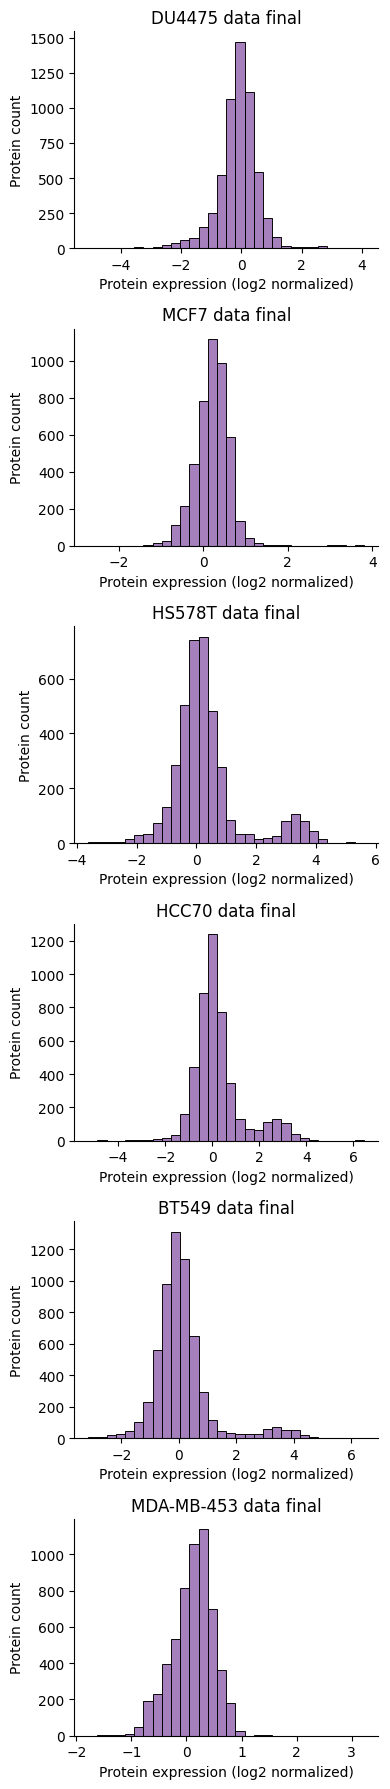

In [15]:
# Plot histogram of `data_final` for each cell line
plt.clf()
fig, axes = plt.subplots(len(cell_lines), 1, figsize=(4, 3 * len(cell_lines)))
for i, cell_line in enumerate(cell_lines):
    last_timepoint_compounds = [compound for compound in data_final[cell_line].columns if compound.endswith("48")]
    data_final_last_timepoint = data_final[cell_line].loc[:, last_timepoint_compounds]  # Last timepoint
    sns.histplot(data_final_last_timepoint.values.flatten(), bins=30, color="#8856a7", ax=axes[i])
    sns.despine()
    axes[i].set_title(f"{cell_line} data final")
    axes[i].set_xlabel("Protein expression (log2 normalized)")
    axes[i].set_ylabel("Protein count")
plt.tight_layout()
plt.show()

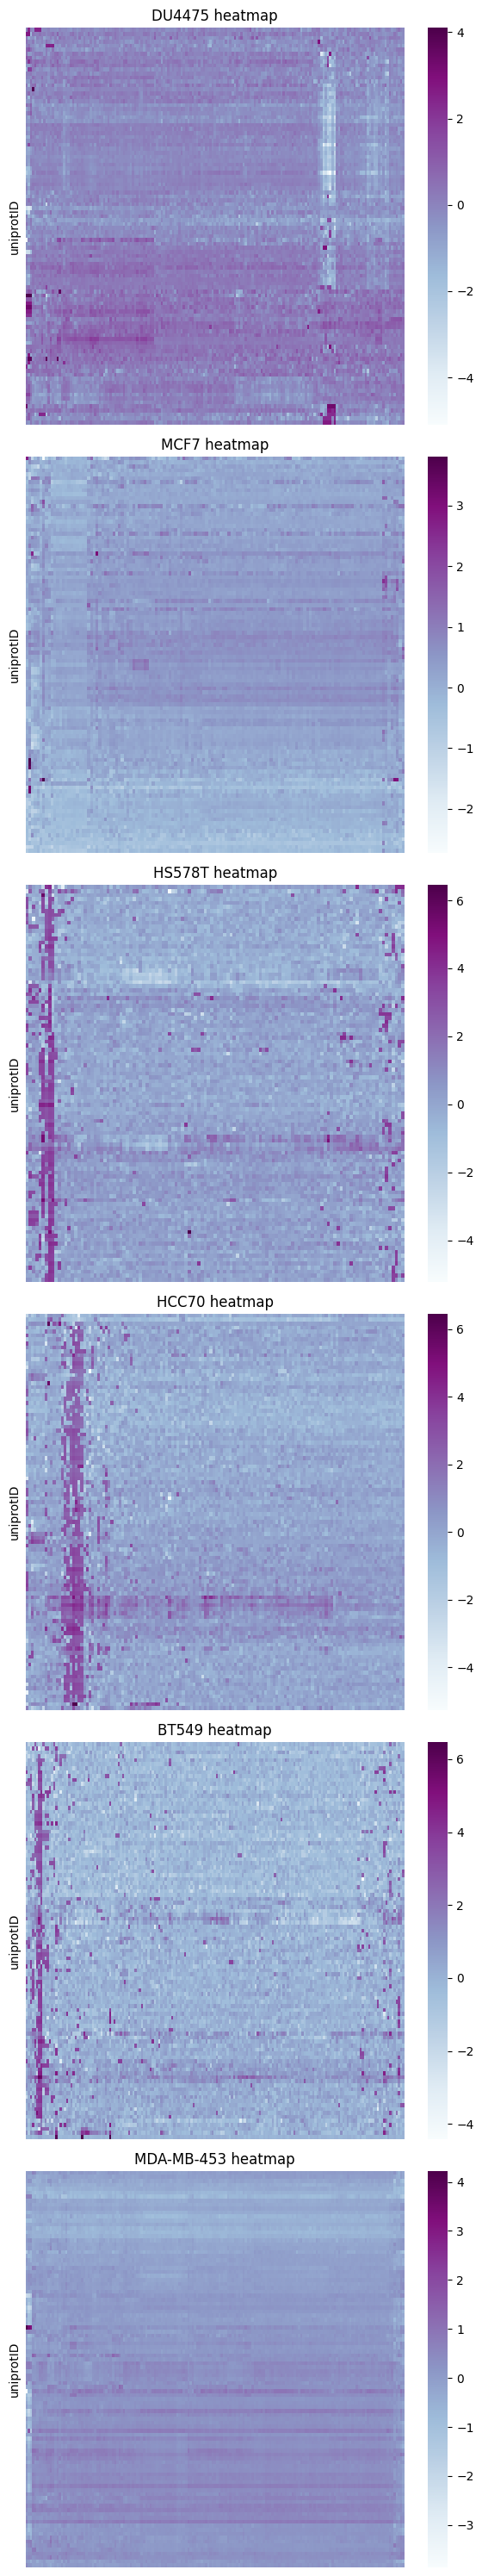

In [ ]:
def cluster_data(data, cell_line):
    gene_linkage_matrix = linkage(data, method='average', metric="cosine")
    row_order = leaves_list(gene_linkage_matrix)
    exp_linkage_matrix = linkage(data.T, method='average', metric="cosine")
    col_order = leaves_list(exp_linkage_matrix)
    data = data.iloc[row_order, col_order]

    # Extract gene clusters
    for dist in np.linspace(0.01, 1, 20):
        gene_clusters = fcluster(gene_linkage_matrix, dist, criterion="distance")
        unique_clusters = len(np.unique(gene_clusters))
        if 5 <= unique_clusters <= 20:
            break

    # Assign cluster labels to genes
    clusters = {}
    for cluster_idx in np.unique(gene_clusters):
        clusters[int(cluster_idx)] = list(data.index[gene_clusters == cluster_idx])

    return data, clusters

fig, axes = plt.subplots(len(cell_lines), 1, figsize=(6, 5 * len(cell_lines)))

# Plot clustermaps for each cell line
cell_line_clusters = {}
for i, cell_line in enumerate(cell_lines):
    data_final_cell = data_final[cell_line]
    data_final_cell, clusters = cluster_data(data_final_cell, cell_line)
    cell_line_clusters[cell_line] = clusters
    sns.heatmap(data_final_cell, ax=axes[i], cmap="BuPu")
    axes[i].set_title(f"{cell_line} heatmap")

    # Remove x and y tick labels
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
# Perform enrichment test on each cluster across each cell line
def perform_enrichment_test(cell_line, cluster_number, cluster):
    r = requests.post(
        url="https://biit.cs.ut.ee/gprofiler/api/gost/profile/",
        json={
            "organism":"hsapiens",
            "query": cluster,
            "sources" :["GO"], # Only look into Gene Ontology terms.
            "no_evidences":True, # Skip lookup for evidence codes. Speeds up queries, if there is no interest in evidence codes.
            "no_iea":True, # Ignore electonically annotated GO annotations
        },
        headers={
            "User-Agent":"FullPythonRequest"
        }
    )
    result = r.json()["result"]
    result_data = None
    if result:
        result_data = []
        for result_dct in result:
            result_data.append([cell_line, cluster_number, len(cluster), result_dct["name"], result_dct["p_value"], result_dct["source"], result_dct["native"], " ".join(cluster)])
    return result_data

# Iterate over cell lines and clusters and determine enrichment
enrichment_data = []
for cell_line in cell_lines:
    clusters = cell_line_clusters[cell_line]
    for cluster_idx, cluster in clusters.items():
        if len(cluster) < 2:
            continue
        result = perform_enrichment_test(cell_line, cluster_idx, cluster)
        if result is not None:
            enrichment_data += result
enrichment_data = pd.DataFrame(enrichment_data, columns=["Cell line", "Cluster number", "Cluster size", "Term name", "p-value", "Term source", "Term ID", "Cluster members"])
enrichment_data

,Cell line,Cluster number,Cluster size,Term name,p-value,Term source,Term ID,Cluster members
0,DU4475,3,2,NADPH peroxidase activity,0.049753,GO:MF,GO:0050137,Q96FQ6 Q16881
1,DU4475,5,46,RNA binding,0.000002,GO:MF,GO:0003723,P78344 Q15417 P98179 Q09028 P84090 P09467 P396...
2,DU4475,5,46,extracellular exosome,0.000216,GO:CC,GO:0070062,P78344 Q15417 P98179 Q09028 P84090 P09467 P396...
3,DU4475,5,46,extracellular vesicle,0.000254,GO:CC,GO:1903561,P78344 Q15417 P98179 Q09028 P84090 P09467 P396...
4,DU4475,5,46,extracellular organelle,0.000256,GO:CC,GO:0043230,P78344 Q15417 P98179 Q09028 P84090 P09467 P396...
...,...,...,...,...,...,...,...,...
295,MDA-MB-453,12,55,nicotinamide nucleotide metabolic process,0.043349,GO:BP,GO:0046496,P05387 Q00765 P61978 P62979 P35232 P25705 P125...
296,MDA-MB-453,12,55,nucleoside phosphate catabolic process,0.044881,GO:BP,GO:1901292,P05387 Q00765 P61978 P62979 P35232 P25705 P125...
297,MDA-MB-453,12,55,structural constituent of cytoskeleton,0.046167,GO:MF,GO:0005200,P05387 Q00765 P61978 P62979 P35232 P25705 P125...
298,MDA-MB-453,12,55,cytoplasmic vesicle,0.048915,GO:CC,GO:0031410,P05387 Q00765 P61978 P62979 P35232 P25705 P125...


<Figure size 640x480 with 0 Axes>

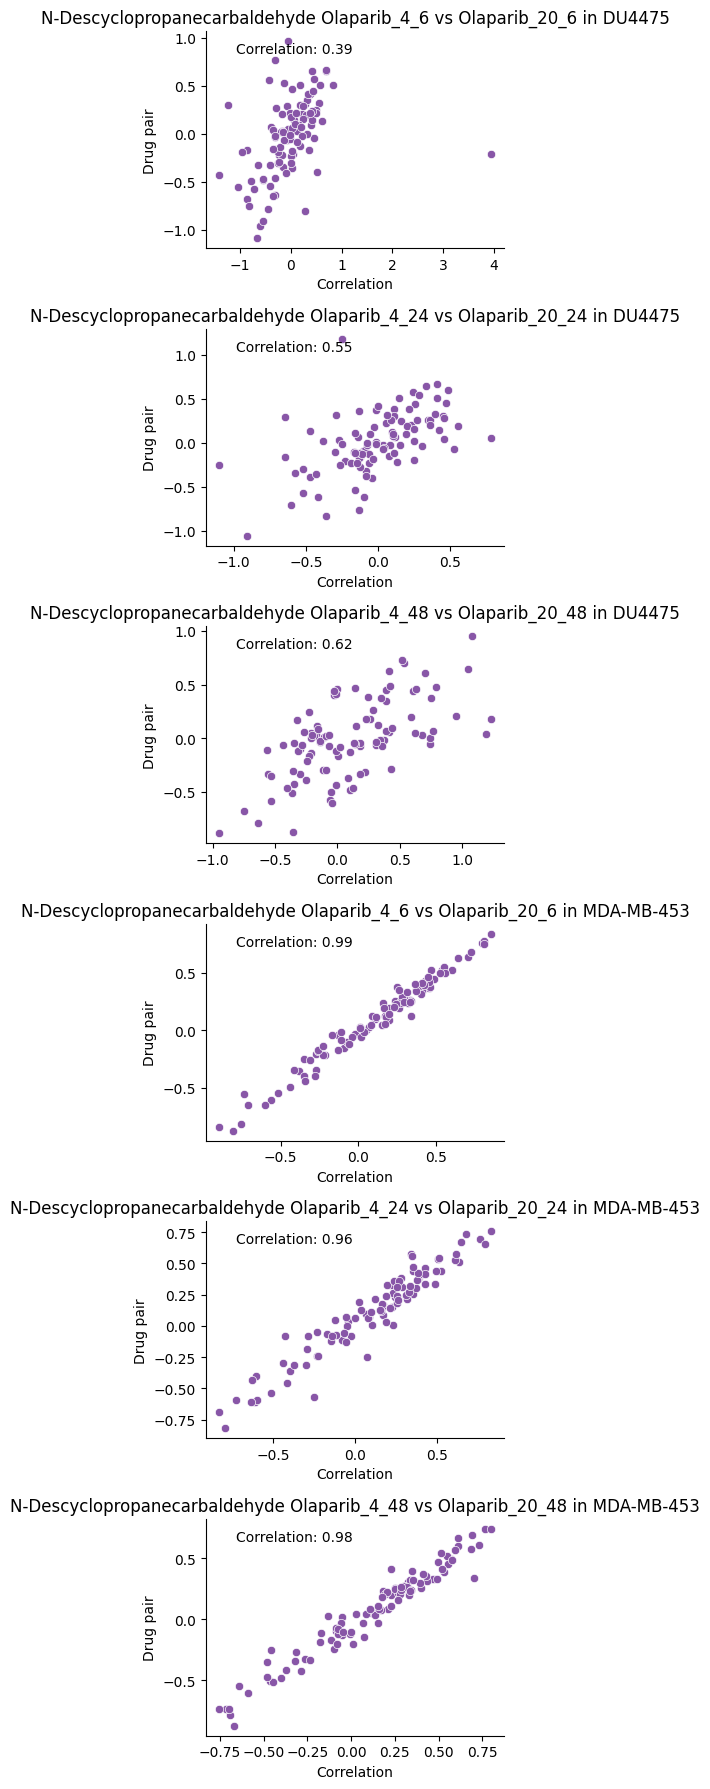

In [ ]:
# Next, sanity check the dataset by plotting scatterplots of drugs with similar names to ensure they correlate
drug_targets = pd.read_excel("/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/ptv1_unique_drug_names.xlsx", sheet_name=0)

# Create drug name mappings
drug_name_mapper = defaultdict(list)
for tup in drug_targets[["original_drug_names", "corrected_drug_name"]].itertuples():
    drug_name_mapper[tup[2]].append(tup[1])

# Iterate over cell lines and identify drugs with similar names
drug_correlations = {}
for cell_line in cell_lines:
    data_final_cell = data_final[cell_line]
    for drug_name, original_names in drug_name_mapper.items():
        if len(original_names) < 2:
            continue
        drug_data = data_final_cell.loc[:, [col for col in data_final_cell.columns if any([original_name == col.split("_")[0] for original_name in original_names])]]
        
        if drug_data.shape[1] <= 3:
            continue
        
        # Split data by time (last integer in column name) and correlate between matching time points
        for timepoint in [6, 24, 48]:
            drug_corr = drug_data.loc[:, [col for col in drug_data.columns if col.endswith(f"_{timepoint}")]]
            drug_correlations[f"{cell_line}_{drug_name}_{timepoint}"] = drug_corr

# Plot scatterplots of drug correlations
plt.clf()
fig, axes = plt.subplots(len(drug_correlations), 1, figsize=(4, 3 * len(drug_correlations)))
for i, (label, drug_corr) in enumerate(drug_correlations.items()):
    drug_names = drug_corr.columns
    sns.scatterplot(x=drug_corr.iloc[:, 0], y=drug_corr.iloc[:, 1], ax=axes[i], color="#8856a7")
    axes[i].set_title(f"{drug_names[0]} vs {drug_names[1]} in {label.split('_')[0]}")
    axes[i].set_xlabel("Correlation")
    axes[i].set_ylabel("Drug pair")
    sns.despine(ax=axes[i])

    # Compute correlation and add text to plot
    corr = drug_corr.corr().iloc[0, 1]
    axes[i].text(0.1, 0.9, f"Correlation: {corr:.2f}", transform=axes[i].transAxes)

plt.tight_layout()
plt.show()

Only N-Descyc. Olaparib and Olaparib were screened in the same cell line (DU4475 and MDA-MB-453). MDA-MB-453 has strong correlations between samples but DU4475 does not. Outlier in DU4475, timepoint 6 causes artificially low correlation.

<Figure size 640x480 with 0 Axes>

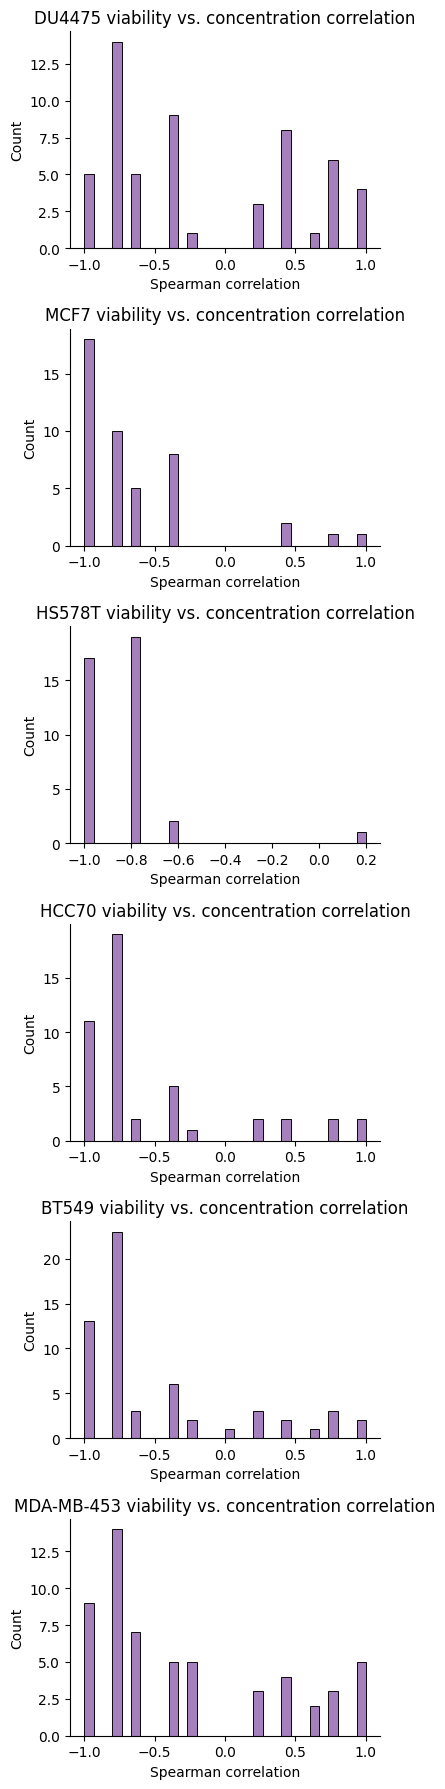

In [ ]:
# Next check correlation of viability with compound concentration
viability = pd.read_excel("/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/cell_viability_sampleinfo_for_chris.xlsx", sheet_name=0)

# Viability across concentrations column names
viab_col_names = ["Inhi_05", "Inhi_5", "inhi_50", "inhi_200"]
concentrations = [0.05, 5, 50, 200]

correlations = {}
for cell_line in cell_lines:
    viability_cell = viability[viability["Cell"] == cell_line]
    
    # Determine spearman correlations for each drug
    correlations_cell = []
    for drug in pd.unique(viability_cell["Pert_iname"]):
        drug_data = viability_cell[viability_cell["Pert_iname"] == drug]
        drug_viab = drug_data[viab_col_names].mean(axis=0).values.flatten() # Take mean, but doesn't look like there are any differences across reps
        if np.isnan(drug_viab).any():
            continue
        drug_corr = spearmanr(concentrations, drug_viab).correlation
        correlations_cell.append(drug_corr)
    
    correlations[cell_line] = correlations_cell
    
# Plot distribution of correlations for each cell line
plt.clf()
fig, axes = plt.subplots(len(correlations), 1, figsize=(4, 3 * len(correlations)))
for i, (cell_line, corrs) in enumerate(correlations.items()):
    sns.histplot(correlations[cell_line], bins=30, color="#8856a7", ax=axes[i])
    axes[i].set_title(f"{cell_line} viability vs. concentration correlation")
    axes[i].set_xlabel("Spearman correlation")
    sns.despine(ax=axes[i])

plt.tight_layout()
plt.show()

Check if estrogen/progesterone receptors and HER2 are low in TN cell lines

<Figure size 640x480 with 0 Axes>

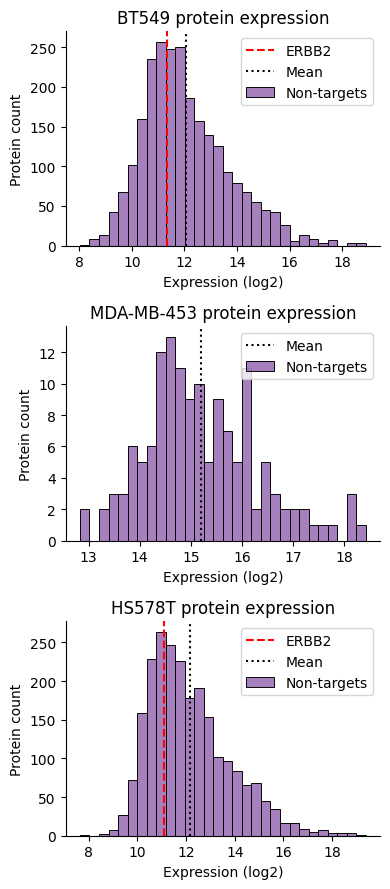

In [ ]:
sensitive_lines = ["BT549", "MDA-MB-453", "HS578T"]
targets = {"P04626": "ERBB2", "P06401": "PGR", "P03372": "ESR1"}

plt.clf()
fig, axes = plt.subplots(len(sensitive_lines), 1, figsize=(4, 3 * len(sensitive_lines)))
for idx, cell_line in enumerate(sensitive_lines):
    # original_data = data_by_cell_line[cell_line]
    original_data = control_data[cell_line].drop(["Standard deviation", "Coefficient of variation"], axis=1)
    common_proteins = list(set(targets.keys()).intersection(original_data.index))
    
    # Compute log-transform of expression counts
    original_data = np.log2(original_data + 1)

    # Get data for target proteins and non-target proteins
    original_data_common = original_data.loc[common_proteins, :]
    original_data_no_common = original_data.drop(common_proteins, axis=0)

    # Take mean across experiments
    original_data_common = original_data_common.mean(axis=1, skipna=True)
    original_data_no_common = original_data_no_common.mean(axis=1, skipna=True)

    # Plot distribution of non-target proteins
    sns.histplot(original_data_no_common, bins=30, color="#8856a7", ax=axes[idx], label="Non-targets")

    # Iterate over target proteins and plot dashed line indicating expression value
    for common_protein in common_proteins:
        protein_data = original_data_common.loc[common_protein]
        axes[idx].axvline(protein_data, color="red", linestyle="--", label=f"{targets[common_protein]}")
    
    # Plot mean of distribution as a dotted line
    axes[idx].axvline(original_data_no_common.mean(), color="black", linestyle=":", label="Mean")

    sns.despine(ax=axes[idx])
    axes[idx].set_title(f"{cell_line} protein expression")
    axes[idx].set_xlabel("Expression (log2)")
    axes[idx].set_ylabel("Protein count")
    axes[idx].legend()

plt.tight_layout()
plt.show()
    

Try correlating wild-type expression across cell lines with Goncalves 2022 (https://www.sciencedirect.com/science/article/pii/S1535610822002744?via%3Dihub)

<Figure size 640x480 with 0 Axes>

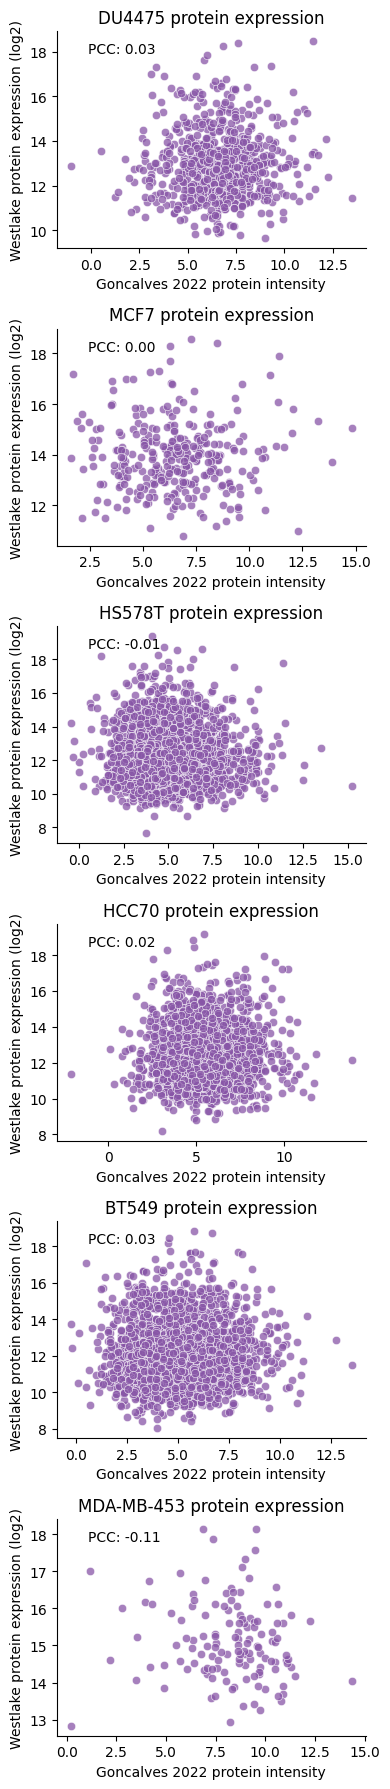

In [ ]:
cell_line_to_path = {
    "DU4475": "/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/CMP_DU-4475_proteomics.csv",
    "MCF7": "/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/CMP_MCF7_proteomics.csv",
    "HS578T": "/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/CMP_Hs-578-T_proteomics.csv",
    "HCC70": "/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/CMP_HCC70_proteomics.csv",
    "BT549": "/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/CMP_BT-549_proteomics.csv",
    "MDA-MB-453": "/home/duf354/perturbation-biology/westlake_project/breast_cancer_exploration_notebooks/notebooks/data_preprocessing/CMP_MDA-MB-453_proteomics.csv",
}

plt.clf()
fig, axes = plt.subplots(len(cell_line_to_path), 1, figsize=(4, 3 * len(cell_line_to_path)))
for idx, (cell_line, path) in enumerate(cell_line_to_path.items()):
    goncalves = pd.read_csv(path, index_col=0)
    original_data = control_data[cell_line].drop(["Standard deviation", "Coefficient of variation"], axis=1)

    # Compute log-transform of expression counts
    original_data = np.log2(original_data + 1)

    # Get common proteins between each dataset
    common_proteins = list(set(goncalves.index).intersection(original_data.index))
    goncalves = goncalves.loc[common_proteins]

    # Group by index and take mean, ensuring only numeric columns are included
    goncalves = goncalves.select_dtypes(include=[np.number]).groupby(goncalves.index).mean()

    original_data = original_data.loc[common_proteins]

    # Plot scatterplot of protein expression values
    sns.scatterplot(x=goncalves["Protein Intensity"].values, y=original_data.mean(axis=1).values, ax=axes[idx], color="#8856a7", alpha=0.75)
    sns.despine()
    axes[idx].set_title(f"{cell_line} protein expression")
    axes[idx].set_xlabel("Goncalves 2022 protein intensity")
    axes[idx].set_ylabel("Westlake protein expression (log2)")

    # Compute pearson correlation and add text to plot
    corr = pearsonr(goncalves["Protein Intensity"].values, original_data.mean(axis=1).values).correlation
    axes[idx].text(0.1, 0.9, f"PCC: {corr:.2f}", transform=axes[idx].transAxes)

plt.tight_layout()
plt.show()

#### Notes
- What do measurements represent and what/how was the cutoff chosen? Can we get the data without a cutoff applied?
- Only 14 cell lines yet manuscript reports 18
- High variability around wild-type control replicates
- Protein clusters have little enrichment
- Perturbations appear to only be for 6, 24 and 48 hours - no time 0 except for control
- Odd data artifact: sample id 3472 has mainly missing values but mean of non-NaN values is 249,115,313 - this is ~4 orders of magnitude higher than other experiments
- Viability information only present at 24 hours - why not 6 and 48?
- Viability doesn't always anticorrelate with concentration
- Only ERBB2 present in dataset, why weren't PGR or ESR1 measured?
- No correlation between untreated protein levels and published intensities from Goncalves 2022